In [1]:
%matplotlib notebook
import os
import time
import numpy as np
import csv
import pandas as pd
import copy
from sklearn.cluster import KMeans

from tqdm import tqdm
import time
import math

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from load_from_coords_1 import align_if_not_aligned_yet
from classes.Settings import Settings
from calc_avg_fragment_2 import read_results_alignment, make_avg_fragment_if_not_exists
from plot_contact_atoms_3 import make_coordinate_df
from calc_density_4 import count_points_per_square

from helpers.plot_functions import plot_density, plot_fragment_colored, plot_vdw_spheres
from helpers.density_helpers import prepare_df, find_available_volume
from helpers.geometry_helpers import (make_coordinate_df,
                                      get_vdw_distance_contact)


central_groups = ["RCOMe",  "H2O", "ArCI", "NO3", "RC6F5",] #,"RNO2", "RC6H5"
contact_groups = ["CF", "RCN", "R2CO", "XH", "CCH3", "C2CH2", "RC6H5", "ArCH"] #  
to_count =       ["F",   "N",    "O",   "H",   "H",     "H", "centroid", "H"]
resolutions = np.arange(0.1, 1.1, 0.1)

In [2]:
def make_density_plot(avg_fragment, density_df, settings):
    fig = plt.figure()
    
    ax: Axes3D = fig.add_subplot(111, projection='3d')
    ax.set_title(settings.central_group_name + "-" + settings.contact_group_name + " resolution: " + str(settings.resolution))
    ax = plot_fragment_colored(ax, avg_fragment)

    p, ax = plot_density(ax=ax, df=density_df, settings=settings)

    ax.set_title("4D density plot\n Resolution: " + str(settings.resolution))
    
    fig.colorbar(p)
    plt.savefig('results/directionality_tests/' + settings.central_group_name  + "/" + settings.central_group_name + "_" + settings.contact_group_name + "_1_resolution_" + str(settings.resolution) + '.png')
#     plt.close()

In [3]:
def calc_clusters(density_df, amount_of_clusters):
    to_cluster_df = density_df[density_df['to_cluster']]
    
    X = np.transpose(np.array([to_cluster_df.x_center, to_cluster_df.y_center, to_cluster_df.z_center]))

    kmeans = KMeans(n_clusters=amount_of_clusters, random_state=1)
    kmeans.fit(X)
    
    density_df.loc[density_df['to_cluster'], "cluster"] = kmeans.labels_
    
    return density_df, kmeans.cluster_centers_

In [4]:
def find_bins_to_cluster(settings, fraction):
    
    density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
    print(settings.get_density_df_filename(), settings.get_density_df_key())
    
    density_df["x_center"] = density_df.xstart + 0.5 * settings.resolution
    density_df["y_center"] = density_df.ystart + 0.5 * settings.resolution
    density_df["z_center"] = density_df.zstart + 0.5 * settings.resolution
    
    # normalize
    density_df.loc[:, settings.to_count_contact + "_normalized"] =\
        density_df[settings.to_count_contact] / density_df[settings.to_count_contact].sum()

    # reset cluster color for when you run this cell again
    density_df["cluster_color"] = np.nan
    
    # set a threshold as to determine will belong to a cluster and which ones won't
    # get the upper kwartant
    max_bin = density_df[settings.to_count_contact].max()
    threshold = max_bin * fraction
    print("Threshold k-means:", threshold, "max_bin:", max_bin, "with fraction:", fraction)
  
    density_df["cluster"] = np.nan
    density_df["to_cluster"] = False
    density_df.loc[density_df[settings.to_count_contact] > threshold, 'to_cluster'] = True
    
    return density_df

In [5]:
def recluster(df, settings, recluster_frac):
    amount = settings.to_count_contact
    
    unique_clusters = df.cluster.dropna().unique()

    df["new_cluster"] = np.nan
    
    fullest_bin = []
    for cluster_id in unique_clusters:
        
        max_bin = df[df.cluster == cluster_id][amount].max()
        
        # add old bins that are full enough when using local maximum
        fraction = max_bin * recluster_frac
        print("Cluster id: " + str(cluster_id), " max bin: " + str(max_bin) + " fraction for this bin: ", fraction)
        df.loc[((df.cluster == cluster_id) & (df[amount] > fraction)), 'new_cluster'] = cluster_id      
            
        # add bins in "x" radius around the local maximums
        new_found = True
        
        # search 1 bins further in all directions
        radius = settings.resolution
        
        # while new bins that belong to the cluster are found, keep expanding
        while new_found:
            old_length = len(df[df.new_cluster == cluster_id])
            
            for _, row in df[df.new_cluster == cluster_id].iterrows():
                df.loc[(df.x_center > row.x_center - radius) & (df.x_center < row.x_center + radius) & 
                    (df.y_center > row.y_center - radius) & (df.y_center < row.y_center + radius) &
                    (df.z_center > row.z_center - radius) & (df.z_center < row.z_center + radius) &
                    (df[amount] > fraction) & (df.new_cluster.isna()), 'new_cluster'] = cluster_id
                
            new_length = len(df[df.new_cluster == cluster_id])
            
            if new_length <= old_length:
                new_found = False
        
    return df

In [6]:
def calc_directionality(settings, k, kmeans_frac, recluster_frac):
    cluster_count = 0

    # work only with bins that are >0.25*maximum full
    density_df = find_bins_to_cluster(settings=settings, fraction=kmeans_frac)

    # calc for each bin in what cluster it belongs
    density_df, centroids = calc_clusters(density_df, k)
    density_df.drop(columns=["to_cluster"])
    
    # find the volume of the central group
    tolerance = 0.5

    df = read_results_alignment(settings.get_aligned_csv_filename())
    avg_fragment = make_avg_fragment_if_not_exists(settings, df)

    coordinate_df = make_coordinate_df(df, settings, avg_fragment)
    contact_radius = coordinate_df['longest_vdw'].mean()

    available_volume = find_available_volume(avg_fragment=avg_fragment, extra=(tolerance + contact_radius))
    
    if not k == 1:
        print("\nRecluster")
        density_df = recluster(density_df, settings, recluster_frac)
        
    return density_df, centroids, available_volume

In [7]:
def show_directionality(avg_fragment, df, column, settings, available_volume, kfrac, recluster_frac):
    colors = ["red", "green", "blue", "purple", "yellow", "pink", "orange", "grey"]
    
    df["cluster_color"] = "grey"

    df.loc[df[column].notna(), "cluster_color"] = [colors[int(i)] for i in list(df.loc[df[column].notna(), column])]
    df = df[df[settings.to_count_contact + "_normalized"] > 0]

    fig = plt.figure(figsize=(8,8))
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    rest = df[df.cluster_color != "grey"]
    
    clusters = df[column].dropna().unique()
    k = len(clusters)
    
    for cluster_id in clusters:
        points = df[df[column] == cluster_id]
        firstpoint = points.iloc[0]
        volume = len(points) * settings.resolution**3
        fraction = points[settings.to_count_contact + "_normalized"].sum()
        directionality = fraction/volume * available_volume
        
        ax.scatter(firstpoint.x_center, firstpoint.y_center, firstpoint.z_center,\
                    label="Cluster: " + str(cluster_id) + " Directionality:" + str(round(directionality, 2)),\
                    color=firstpoint.cluster_color)
    
    ax.scatter(list(rest.x_center), list(rest.y_center), list(rest.z_center),
               color=list(rest.cluster_color))
    
    # plot the average fragment
    ax = plot_fragment_colored(ax, avg_fragment)

    ax.set_title("Clusters " + settings.central_group_name + "-" + settings.contact_group_name + ", resolution: " + str(settings.resolution) + "\n" + column)
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    
    ax.legend(fontsize='x-small')
    
    elev = 89
    azim = -89
    ax.view_init(elev=elev, azim=azim)
    
    print(ax.azim, ax.elev)
    plt.show()
    
    plt.savefig('results/directionality_tests/' + settings.central_group_name + "/" + settings.central_group_name +\
                "_" + settings.contact_group_name + "_k_" + str(k) + "_resolution_" + str(settings.resolution) +\
                "_"  + column + "_kfrac_" + str(kfrac) + "_refrac_" + str(recluster_frac) + ".png")
#     plt.close()

In [15]:
cluster_amounts = {"ArCI": {"CF": 8, "RCN": 1, "R2CO": 1, "XH": 2, "CCH3": 1, "C2CH2": 1, "RC6H5": 1, "ArCH": 1},
                   "H2O": {"CF": 3, "RCN": 2, "R2CO": 2, "XH": 3, "CCH3": 1, "C2CH2": 1, "RC6H5": 3, "ArCH": 1},
                   "NO3": {"CF": 1, "RCN": 1, "R2CO": 1, "XH": 3, "CCH3": 1, "C2CH2": 1, "RC6H5": 1, "ArCH": 1},
                   "RC6F5": {"CF": 5, "RCN": 1, "R2CO": 7, "XH": 2, "CCH3": 1, "C2CH2": 1, "RC6H5": 3, "ArCH": 1},
                   "RC6H5": {"CF": 4, "RCN": 4, "R2CO": 1, "XH": 1, "CCH3": 1, "C2CH2": 1, "RC6H5": 0, "ArCH": 0},
                   "RNO2": {"CF": 1, "RCN": 1, "R2CO": 1, "XH": 3, "CCH3": 1, "C2CH2": 1, "RC6H5": 1, "ArCH": 1},
                   "RCOMe": {"CF": 1, "RCN": 1, "R2CO": 1, "XH": 1, "CCH3": 1, "C2CH2": 1, "RC6H5": 1, "ArCH": 1}}

RNO2 CF
.\results\RNO2\RNO2_CF_vdw.5\RNO2_CF_vdw.5_density.hdf F03
Threshold k-means: 1.5 max_bin: 15.0 with fraction: 0.1
Available volume: 294.98300000000006


<IPython.core.display.Javascript object>


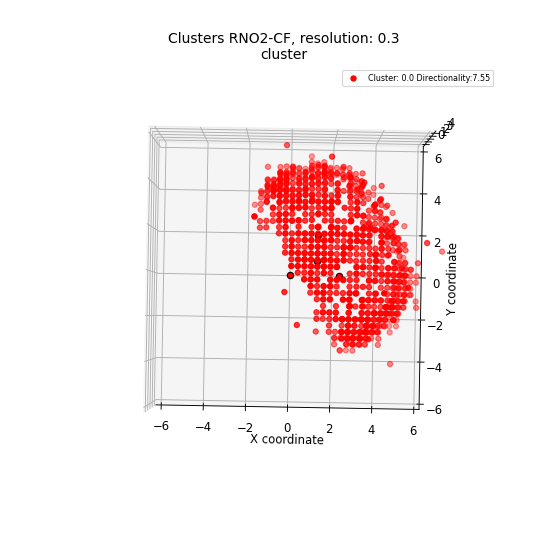

-89 89
RNO2 RCN
.\results\RNO2\RNO2_RCN_vdw.5\RNO2_RCN_vdw.5_density.hdf N03
Threshold k-means: 1.8 max_bin: 18.0 with fraction: 0.1
Available volume: 311.88400000000007


<IPython.core.display.Javascript object>


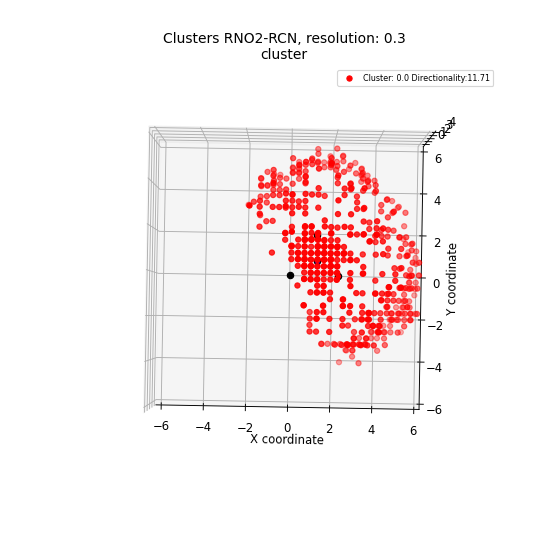

-89 89
RNO2 R2CO
.\results\RNO2\RNO2_R2CO_vdw.5\RNO2_R2CO_vdw.5_density.hdf O03
Threshold k-means: 14.700000000000001 max_bin: 147.0 with fraction: 0.1
Available volume: 306.1400000000001


<IPython.core.display.Javascript object>


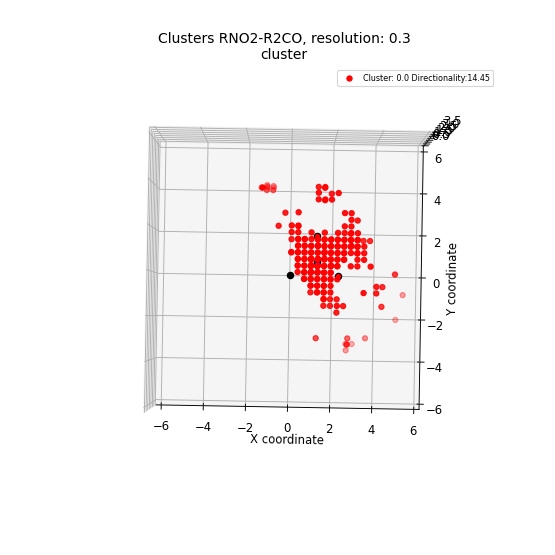

-89 89
RNO2 XH
.\results\RNO2\RNO2_XH_vdw.5\RNO2_XH_vdw.5_density.hdf H03
Threshold k-means: 33.9 max_bin: 339.0 with fraction: 0.1

Recluster
Cluster id: 1.0  max bin: 228.0 fraction for this bin:  57.0
Cluster id: 2.0  max bin: 266.0 fraction for this bin:  66.5
Cluster id: 0.0  max bin: 339.0 fraction for this bin:  84.75
Available volume: 204.09900000000005


<IPython.core.display.Javascript object>


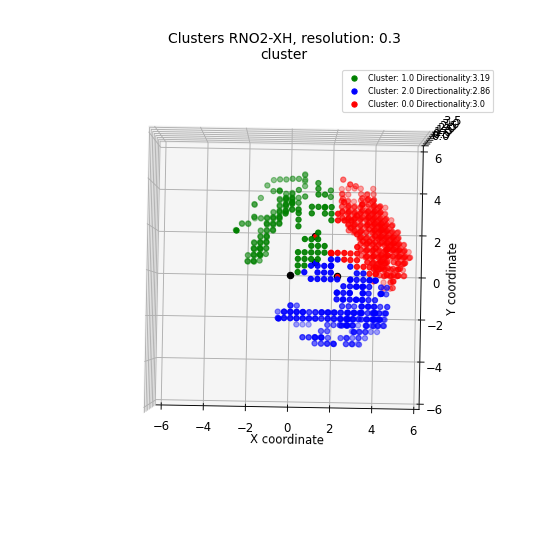

-89 89


<IPython.core.display.Javascript object>


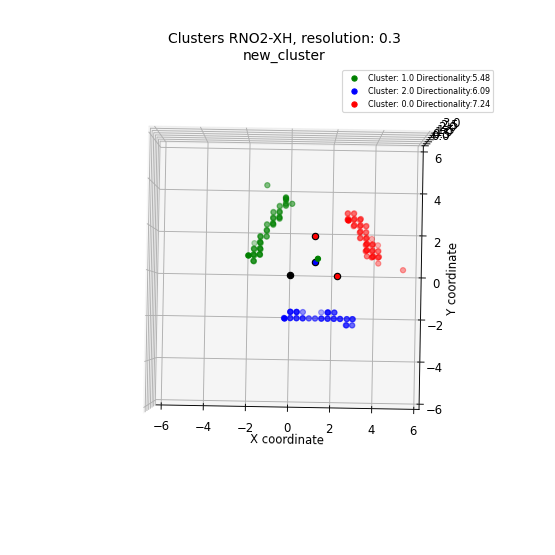

-89 89
RNO2 CCH3
.\results\RNO2\RNO2_CCH3_vdw.5\RNO2_CCH3_vdw.5_density.hdf H03
Threshold k-means: 5.2 max_bin: 52.0 with fraction: 0.1
Available volume: 209.00700000000006


<IPython.core.display.Javascript object>


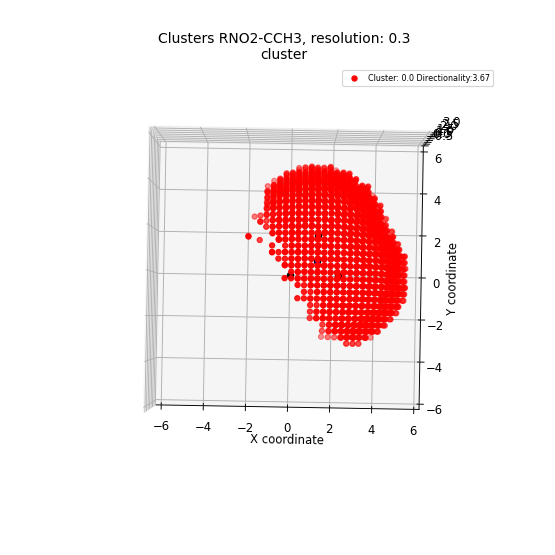

-89 89
RNO2 C2CH2
.\results\RNO2\RNO2_C2CH2_vdw.5\RNO2_C2CH2_vdw.5_density.hdf H03
Threshold k-means: 4.0 max_bin: 40.0 with fraction: 0.1
Available volume: 208.65900000000005


<IPython.core.display.Javascript object>


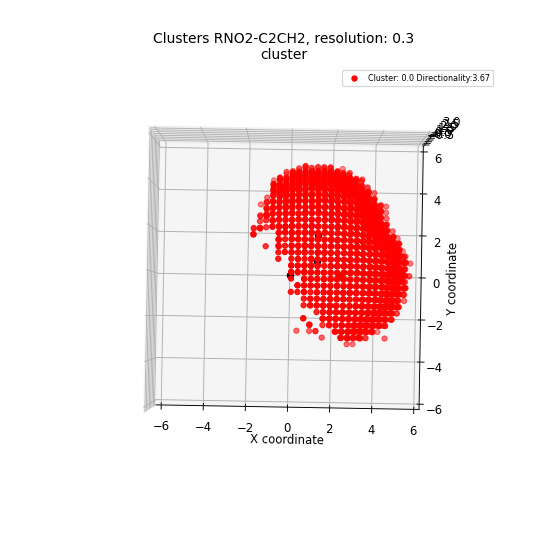

-89 89


In [20]:
if not os.path.exists('results/directionality_tests/'):
    os.mkdir('results/directionality_tests/')


kfrac = 0.1
recluster_frac = 0.25
    
central_groups = ["RNO2"]
    
for central in central_groups:
    for contact, to_count_contact in zip(contact_groups[:-2], to_count[:-2]):
        if not os.path.exists('results/directionality_tests/' + central + "/"):
            os.mkdir('results/directionality_tests/' + central + "/")
        
        print(central, contact)

        filename = ".\\results\\" + central + "\\" + central + "_" + contact + "_vdw.5" + "\\" + central + "_" + contact + "_vdw.5_aligned.csv"
        settings = Settings(filename)
        settings.set_atom_to_count(to_count_contact)
        settings.set_resolution(round(0.3, 2))
        
        df = read_results_alignment(settings.get_aligned_csv_filename())
        avg_fragment = make_avg_fragment_if_not_exists(settings, df)
        
#         density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
         
#         make_density_plot(avg_fragment, density_df, settings)

        density_df, centroids, V_available = calc_directionality(settings=settings,
                                      k=cluster_amounts[central][contact], 
                                      kmeans_frac=kfrac,
                                      recluster_frac=recluster_frac)

        print("Available volume:", V_available)
        show_directionality(avg_fragment, density_df, 'cluster', settings, V_available, kfrac, recluster_frac)
        
        if cluster_amounts[central][contact] >1:
            show_directionality(avg_fragment, density_df, 'new_cluster', settings, V_available, kfrac, recluster_frac)